In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import os, sys

import matplotlib.pyplot as plt

from models import GATRegressor,GATv2Regressor

In [12]:
## This are the configuration of all the parameters

ModelOutDIR = "Bsize64_lr5e-4_NOnormNodes/"
BatchSize = 64
LearningRate = 0.0005
Epochs = 500
UsingOnly = 2


In [13]:
import os
## check if EOS folder exists otherwise use local folder
if os.path.exists("/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241015/"):
    GraphDIR = "/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241015/"
else:
    GraphDIR = "../graph_folder/"

Allgraphs = []
all_files = os.listdir(GraphDIR)

# Filter for .pkl files
pkl_files = [f for f in all_files if f.endswith('.pkl') and '_3_' in f]
print(f"Using files: {pkl_files}")
if not pkl_files:
    print("No .pkl files found in the directory.")
    sys.exit()

count_files = 0
for pkl_file in pkl_files:
    if count_files > UsingOnly: break
    file_path = os.path.join(GraphDIR, pkl_file)
    print(f"Loading file: {pkl_file}")
    with open(file_path, 'rb') as file:
        graphfile = torch.load(file)
        Allgraphs.append(graphfile)
    count_files+=1

Using files: ['vix_graph_3_15Oct_onlypt_001.pkl', 'vix_graph_3_15Oct_onlypt_002.pkl', 'vix_graph_3_15Oct_onlypt_003.pkl', 'vix_graph_3_15Oct_onlypt_004.pkl', 'vix_graph_3_15Oct_onlypt_005.pkl', 'vix_graph_3_15Oct_onlypt_006.pkl', 'vix_graph_3_15Oct_onlypt_007.pkl', 'vix_graph_3_15Oct_onlypt_008.pkl', 'vix_graph_3_15Oct_onlypt_009.pkl']
Loading file: vix_graph_3_15Oct_onlypt_001.pkl


C:\Users\folguerassantiago\AppData\Local\Temp\ipykernel_21088\4025464192.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphfile = torch.load(file)


Loading file: vix_graph_3_15Oct_onlypt_002.pkl
Loading file: vix_graph_3_15Oct_onlypt_003.pkl


## Load data

In [ ]:
import torch_geometric.transforms as T
                   
Graphs_for_training = sum(Allgraphs, [])
Graphs_for_training_reduced = Graphs_for_training
Graphs_for_training_filtered = [g for g in Graphs_for_training_reduced if g.edge_index.size(1) > 0]  # remove empty graphs

# remove extra dimenson in y
print(f"Total Graphs: {len(Graphs_for_training)}")
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")
for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)

# Train and test split:
events = len(Graphs_for_training_filtered)
ntrain = int((events * 0.7) / BatchSize) * BatchSize  # to have full batches
print(f"Training events: {ntrain}")

print(Graphs_for_training_filtered[0].x)

transform = T.Compose([T.NormalizeFeatures()])

train_dataset = Graphs_for_training_filtered[:ntrain]
test_dataset = Graphs_for_training_filtered[ntrain:ntrain * 2]

for i in range(0, len(train_dataset)):
    train_dataset[i].edge_attr = torch.stack([train_dataset[i].deltaPhi.float(), train_dataset[i].deltaEta.float()], dim=1)
        

print("====================================")
print("Example of data:")
print(train_dataset[0].x)
print(train_dataset[0].edge_index)
print(train_dataset[0].deltaPhi)
print(train_dataset[0].deltaEta)
print(train_dataset[0].edge_attr)
print(train_dataset[0].y)
print("====================================")

# Load data
train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

Total Graphs: 167346
Total Graphs after filtering: 167259
Training events: 117056
tensor([[1.0331e+00, 9.8300e+02, 1.0060e+03, 6.0000e+00, 9.0000e+00],
        [1.0114e+00, 9.7700e+02, 1.0767e+03, 1.5000e+01, 5.0000e+00],
        [1.0440e+00, 9.9100e+02, 1.1959e+03, 7.0000e+00, 9.0000e+00],
        [1.1092e+00, 9.5400e+02, 4.1368e+02, 1.0000e+01, 5.0000e+00]],
       dtype=torch.float64)
Example of data:
tensor([[1.0331e+00, 9.8300e+02, 1.0060e+03, 6.0000e+00, 9.0000e+00],
        [1.0114e+00, 9.7700e+02, 1.0767e+03, 1.5000e+01, 5.0000e+00],
        [1.0440e+00, 9.9100e+02, 1.1959e+03, 7.0000e+00, 9.0000e+00],
        [1.1092e+00, 9.5400e+02, 4.1368e+02, 1.0000e+01, 5.0000e+00]],
       dtype=torch.float64)
tensor([[0, 0, 0, 1, 1, 2, 2, 3],
        [1, 2, 3, 0, 2, 0, 1, 0]])
tensor([ -6,   8, -29,  -6, -14,   8, -14, -29])
tensor([-0.0217,  0.0109,  0.0761, -0.0217, -0.0326,  0.0109, -0.0326,  0.0761])
tensor([[-6.0000e+00, -2.1750e-02],
        [ 8.0000e+00,  1.0875e-02],
        [-2.

In [ ]:
import numpy as np

def normalize_data(graphs, normalize_features=True, normalize_targets=True, normalize_edge_features=True):
    if normalize_features:
        print("Normalizing features")
        for i in range(5):
            feature = [x.x[:, i] for x in graphs]
            feature = torch.cat(feature, dim=0)
            mean = feature.mean()
            std = feature.std()
            for x in graphs:
                x.x[:, i] = (x.x[:, i] - mean) / std
                x.x[:, i] = x.x[:, i].float()

    if normalize_targets:
        print("Normalizing targets")
        target = [x.y.unsqueeze(0) if x.y.dim() == 0 else x.y for x in graphs]  # Asegúrate de que x.y tenga al menos una dimensión
        target = torch.cat(target, dim=0)
        mean = target.mean()
        std = target.std()
        for x in graphs:
            x.y = (x.y - mean) / std
            x.y = x.y.float()

    if normalize_edge_features:
        print("Normalizing edge features")
        for i in range(2):
            feature = [x.edge_attr[:, i] for x in graphs]
            feature = torch.cat(feature, dim=0)
            mean = feature.mean()
            std = feature.std()
            for x in graphs:
                x.edge_attr[:, i] = (x.edge_attr[:, i] - mean) / std
                x.edge_attr[:, i] = x.edge_attr[:, i].float()

for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].edge_attr = torch.stack([Graphs_for_training_filtered[i].deltaPhi.float(), Graphs_for_training_filtered[i].deltaEta.float()], dim=1)

normalize_data(Graphs_for_training_filtered)

print("====================================")
print("Example of data:")
print(Graphs_for_training_filtered[0].x)
print(Graphs_for_training_filtered[0].edge_index)
print(Graphs_for_training_filtered[0].deltaPhi)
print(Graphs_for_training_filtered[0].deltaEta)
print(Graphs_for_training_filtered[0].edge_attr)
print(Graphs_for_training_filtered[0].y)
print("====================================")




Normalizing features
Normalizing targets
tensor(-3.7723e-08)
tensor(1.)
Normalizing edge features
Example of data:
tensor([[ 0.0354,  0.1415,  0.8504, -0.5829,  1.6600],
        [-0.1298,  0.1301,  1.0756,  1.1622, -0.2359],
        [ 0.1180,  0.1568,  1.4553, -0.3890,  1.6600],
        [ 0.6135,  0.0862, -1.0370,  0.1927, -0.2359]], dtype=torch.float64)
tensor([[0, 0, 0, 1, 1, 2, 2, 3],
        [1, 2, 3, 0, 2, 0, 1, 0]])
tensor([ -6,   8, -29,  -6, -14,   8, -14, -29])
tensor([-0.0217,  0.0109,  0.0761, -0.0217, -0.0326,  0.0109, -0.0326,  0.0761])
tensor([[ 0.2979, -0.4236],
        [ 0.4859, -0.0080],
        [-0.0109,  0.8230],
        [ 0.2979, -0.4236],
        [ 0.1905, -0.5621],
        [ 0.4859, -0.0080],
        [ 0.1905, -0.5621],
        [-0.0109,  0.8230]])
tensor(0.7464)


In [33]:
train_dataset = Graphs_for_training_filtered[:ntrain]
test_dataset = Graphs_for_training_filtered[ntrain:ntrain * 2]
       
# Load data
train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

tensor([[  0,   0,   0,  ..., 360, 361, 361],
        [  1,   2,   3,  ..., 361, 360, 359]])


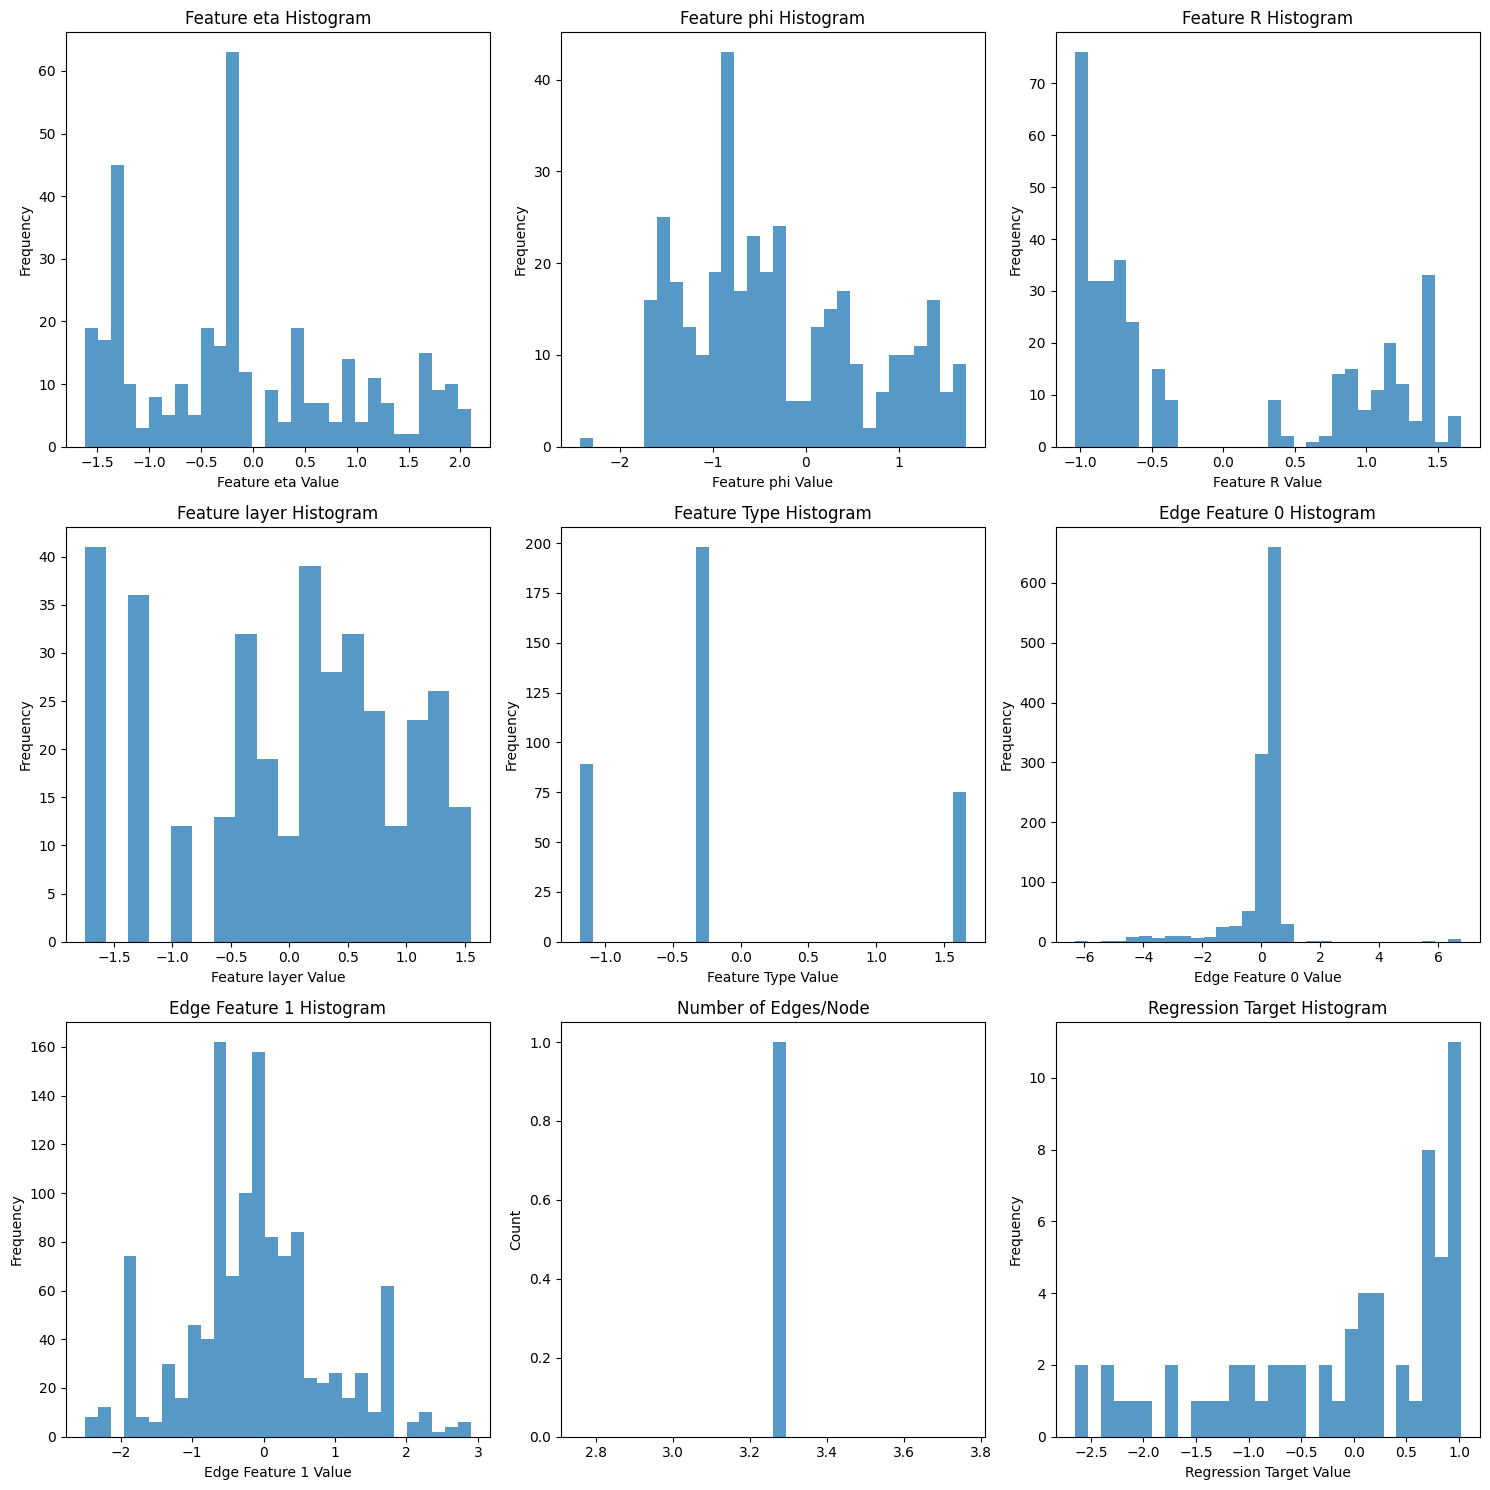

In [38]:
import matplotlib.pyplot as plt

# Function to plot histograms for each feature in the same figure

def plot_histograms(data_loader):   
    feature_names = ["eta", "phi", "R", "layer", "Type"]
    for batch in data_loader:
        features = batch.x.numpy()
        regression = batch.y.numpy()
        deltaphi = batch.deltaPhi.numpy() 
        deltaeta = batch.deltaEta.numpy()
        num_features = features.shape[1]
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        axs = axs.flatten()
        
        # Plot node features
        for i in range(num_features):
            if i==3: 
                nbins = 18
            else :
                nbins = 30
            axs[i].hist(features[:, i], bins=nbins, alpha=0.75)
            axs[i].set_title(f'Feature {feature_names[i]} Histogram')
            axs[i].set_xlabel(f'Feature {feature_names[i]} Value')
            axs[i].set_ylabel('Frequency')
        
        
        # plot the number of edges of each graph
        for i in range(batch.edge_attr.shape[1]):
            axs[i+num_features].hist(batch.edge_attr[:, i], bins=30, alpha=0.75)
            axs[i+num_features].set_title(f'Edge Feature {i} Histogram')
            axs[i+num_features].set_xlabel(f'Edge Feature {i} Value')
            axs[i+num_features].set_ylabel('Frequency')

        print(batch.edge_index)
        #calculate the average number of edges, dividing by the number of nodes
        num_edges = batch.edge_index.size(1)/batch.x.size(0)
        axs[num_features+2].hist(num_edges, bins=30, alpha=0.75)
        axs[num_features+2].set_title('Number of Edges/Node')
        axs[num_features+2].set_ylabel('Count')
        
        # Plot regression target
        axs[num_features + 3].hist(regression, bins=30, alpha=0.75)
        axs[num_features + 3].set_title('Regression Target Histogram')
        axs[num_features + 3].set_xlabel('Regression Target Value')
        axs[num_features + 3].set_ylabel('Frequency')
              
        plt.tight_layout()
        plt.show()
        break  # Only draw the first batch

# Plot histograms for training data
plot_histograms(train_loader)

In [6]:
from models import GATRegressor,GATRegressorDO,GATv2Regressor

In [7]:
num_node_features = 5
num_edge_features = 2
hidden_dim = BatchSize
output_dim = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


model = GATRegressorDO(num_node_features, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=LearningRate, weight_decay=0.75)

criterion = torch.nn.MSELoss()
print("Model, optimizer, and loss criterion initialized")
print(model)
print("====================================")

Using device: cuda
Model, optimizer, and loss criterion initialized
GATRegressorDO(
  (conv1): GATConv(5, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return 100 * (1 - torch.mean(torch.abs(y_pred - y_true) / torch.abs(y_true)))

def train(model, loader):
    model.train()
    total_loss = 0
    total_acc = 0
    for data in loader:
        data.y = data.y.float()  # Asegurarse de que los datos sean float32
        data.x = data.x.float()  # Asegurarse de que los datos sean float32

        out = model(data)
        optimizer.zero_grad()
        loss = criterion(out, data.y.view(out.size()))
        loss.backward()
        optimizer.step()
        total_loss += float(loss)/len(loader)
        total_acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return total_loss, total_acc

def test(model,loader):
    with torch.no_grad():
        model.eval()
        total_loss = 0
        acc = 0

        for data in loader:
            data.x = data.x.float()  # Asegurarse de que los datos sean float32
            data.y = data.y.float()  # Asegurarse de que los datos sean float32
            out = model(data)
            loss = criterion(out, data.y.view(out.size()))
            total_loss += float(loss)/len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

            
    return total_loss, acc

print("Start training...")
import time
train_losses = []
test_losses = []
for epoch in range(Epochs+1):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = test(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if (epoch) % 10 == 0:
        print(f'Epoch: {epoch:02d}, Train loss: {train_loss:.4f}, Train Acc: {train_acc:>5.2f} |  Test loss: {test_loss:.4f}, Test Acc: {test_acc:>5.2f} | Time: {(time.time()-start_time):.2f} seconds')
    
    if (epoch+1) % 100 == 0:
        print(f'Saving model for last epoch and plotting loss...')
        torch.save(model, f"{ModelOutDIR}/model_{epoch + 1}.pth")
    
    if epoch == Epochs:
        print(f'Saving model for last epoch and plotting loss...')
        torch.save(model, f"{ModelOutDIR}/model_{epoch + 1}.pth")
        plt.plot(train_losses, "b", label="Train loss")
        plt.plot(test_losses, "k", label="Test loss")
        plt.yscale('log')
        plt.savefig(f"{ModelOutDIR}/loss_plot.png")
        plt.close()
     
print("Training finished.")



Start training...
Epoch: 00, Train loss: 739.2736, Train Acc:  0.00 |  Test loss: 683.2512, Test Acc:  0.00 | Time: 174.91 seconds
